### Урок 5. Случайный лес

#### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [162]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math

In [163]:
# сгенерируем данные, представляющие собой 10000 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=5000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

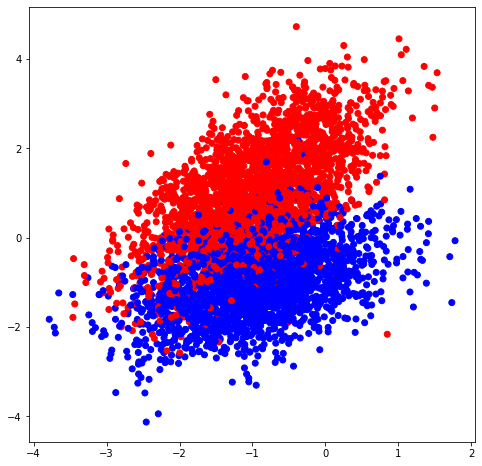

In [164]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [165]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [166]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [167]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [168]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [169]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [170]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [171]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [172]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [173]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [174]:
# Теперь добавим функцию формирования случайного леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [175]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [176]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [177]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [178]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [179]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Построим лес из одного дерева

In [180]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 6.81 s


In [214]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [215]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [216]:
# Точность на обучающей выборке
train_accuracy_1 = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_1:.3f}')

# Точность на тестовой выборке
test_accuracy_1 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_1:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 93.714
Точность случайного леса из 3 деревьев на тестовой выборке: 81.867


Построим лес из трех деревьев

In [205]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 21.7 s


In [199]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [200]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [201]:
# Точность на обучающей выборке
train_accuracy_3 = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_3:.3f}')

# Точность на тестовой выборке
test_accuracy_3 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_3:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 96.743
Точность случайного леса из 50 деревьев на тестовой выборке: 84.667


Построим лес из десяти деревьев

In [188]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 55.8 s


In [206]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [207]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [208]:
# Точность на обучающей выборке
train_accuracy_10 = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_10:.3f}')

# Точность на тестовой выборке
test_accuracy_10 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_10:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.943
Точность случайного леса из 3 деревьев на тестовой выборке: 85.867


Построим лес из пятидесяти деревьев

In [192]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 5min 23s


In [209]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [210]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [211]:
# Точность на обучающей выборке
train_accuracy_50 = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_50:.3f}')

# Точность на тестовой выборке
test_accuracy_50 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_50:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 99.971
Точность случайного леса из 3 деревьев на тестовой выборке: 85.800


Построим лес из ста деревьев

In [232]:
%%time
n_trees = 100
my_forest_100 = random_forest(train_data, train_labels, n_trees)

Wall time: 10min 28s


In [236]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_100, train_data)

In [237]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_100, test_data)

In [238]:
# Точность на обучающей выборке
train_accuracy_100 = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_100:.3f}')

# Точность на тестовой выборке
test_accuracy_100 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_100:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 85.800


Построим лес из ста пятидесяти деревьев

In [231]:
%%time
n_trees = 150
my_forest_150 = random_forest(train_data, train_labels, n_trees)

Wall time: 15min 29s


In [233]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_150, train_data)

In [234]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_150, test_data)

In [235]:
# Точность на обучающей выборке
train_accuracy_150 = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_150:.3f}')

# Точность на тестовой выборке
test_accuracy_150 = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_150:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 86.067


И отобразим все на графиках:

In [196]:
def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
xx, yy = get_meshgrid(classification_data)


Text(0.5, 1.0, 'Cлучайный лес из 150 деревьев. Точность на тестовой выборке: 86.067')

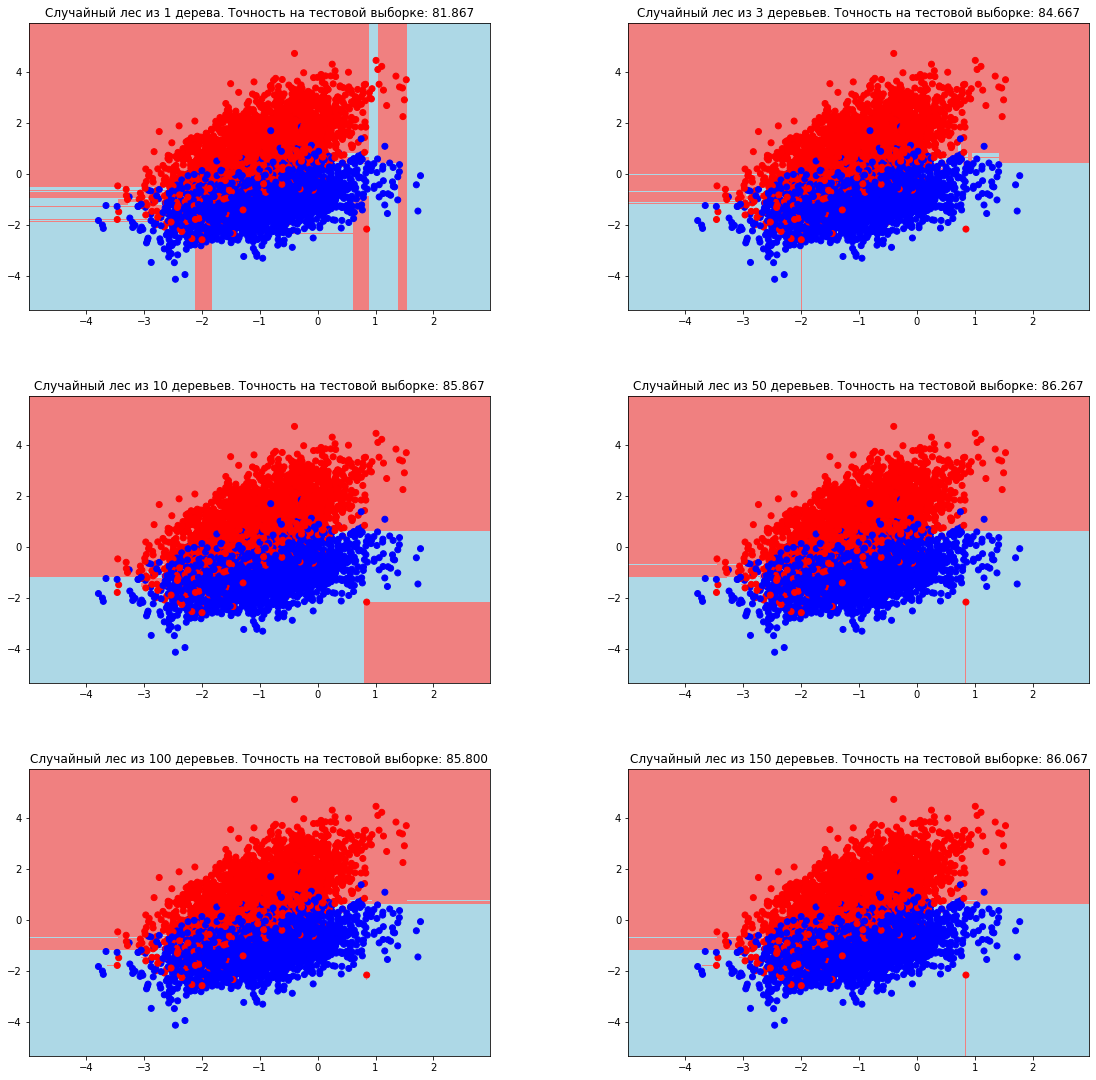

In [239]:
fig, ax = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.set_size_inches(19, 19, forward=True)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

# 1 дерево
mesh_predictions = np.array(tree_vote( my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax1.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax1.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax1.set_title(f'Cлучайный лес из 1 дерева. Точность на тестовой выборке: {test_accuracy_1:.3f}')

# 3 дерева
mesh_predictions = np.array(tree_vote(my_forest_3,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax2.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax2.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax2.set_title(f'Cлучайный лес из 3 деревьев. Точность на тестовой выборке: {test_accuracy_3:.3f}')

# 10 деревьев
mesh_predictions = np.array(tree_vote(my_forest_10,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax3.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax3.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax3.set_title(f'Cлучайный лес из 10 деревьев. Точность на тестовой выборке: {test_accuracy_10:.3f}')

# 50 деревьев
mesh_predictions = np.array(tree_vote(my_forest_50,np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
ax4.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax4.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax4.set_title(f'Cлучайный лес из 50 деревьев. Точность на тестовой выборке: {test_accuracy_50:.3f}')

# 100 деревьев
mesh_predictions = np.array(tree_vote(my_forest_100, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax5.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax5.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax5.set_title(f'Cлучайный лес из 100 деревьев. Точность на тестовой выборке: {test_accuracy_100:.3f}') 

# 150 деревьев
mesh_predictions = np.array(tree_vote(my_forest_150, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax6.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
ax6.scatter(classification_data[:, 0], classification_data[:, 1], c = np.array(classification_labels), cmap = colors)
ax6.set_title(f'Cлучайный лес из 150 деревьев. Точность на тестовой выборке: {test_accuracy_150:.3f}') 





#### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Гиперплоскость при увеличении количества деревьев должна усложняться. К сожалению, на данных графиках это четко не прослеживается. Да и остановится с количеством деревьев надо было на 50 шт. Увеличение количества деревьев не должно приводить к переобучению.

#### 4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Энтропийный критерий_ или _энтропия Шеннона_ :

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

In [ ]:
# Расчет энтропии Шеннона

def shenon(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0: # 0 log2 0 = 0
            impurity == 0
        else:
            impurity -= p * math.log2(p)
        
    return impurity